In [1]:
# 드라이브에 첨부되어 있는 npy 파일 세 개를 저장해주시면 됩니다.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torch torchvision pytorch-lightning==1.8.6 segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 32.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=3e59d7427df07f7ab9b35afec039da7843a8107b94e2d61ef2827f1f63d050e3
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=ec409b4ea396fb60fc931583003b7a46b61e1

In [3]:
import os

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split, ConcatDataset
from segmentation_models_pytorch.datasets import SimpleOxfordPetDataset

In [72]:
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()

        # Contracting Path
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn3_1 = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn4_1 = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.bn4_2 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(2, 2)

        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        self.bn5_1 = nn.BatchNorm2d(1024)
        self.conv5_2 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1)
        self.bn5_2 = nn.BatchNorm2d(1024)

        # Expanding Path
        self.upconv4 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)
        self.conv6_1 = nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1)
        self.bn6_1 = nn.BatchNorm2d(512)
        self.conv6_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.bn6_2 = nn.BatchNorm2d(512)

        self.upconv3 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
        self.conv7_1 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1)
        self.bn7_1 = nn.BatchNorm2d(256)
        self.conv7_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn7_2 = nn.BatchNorm2d(256)

        self.upconv2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.conv8_1 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.bn8_1 = nn.BatchNorm2d(128)
        self.conv8_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn8_2 = nn.BatchNorm2d(128)

        self.upconv1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.conv9_1 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.bn9_1 = nn.BatchNorm2d(64)
        self.conv9_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn9_2 = nn.BatchNorm2d(64)

        self.final_conv = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)

    def forward(self, x):
        x1 = F.relu(self.bn1_1(self.conv1_1(x)))
        x1 = F.relu(self.bn1_2(self.conv1_2(x1)))
        p1 = self.pool1(x1)

        x2 = F.relu(self.bn2_1(self.conv2_1(p1)))
        x2 = F.relu(self.bn2_2(self.conv2_2(x2)))
        p2 = self.pool2(x2)

        x3 = F.relu(self.bn3_1(self.conv3_1(p2)))
        x3 = F.relu(self.bn3_2(self.conv3_2(x3)))
        p3 = self.pool3(x3)

        x4 = F.relu(self.bn4_1(self.conv4_1(p3)))
        x4 = F.relu(self.bn4_2(self.conv4_2(x4)))
        p4 = self.pool4(x4)

        x5 = F.relu(self.bn5_1(self.conv5_1(p4)))
        x5 = F.relu(self.bn5_2(self.conv5_2(x5)))

        u4 = self.upconv4(x5)
        x4 = torch.cat([x4, u4], dim=1)
        x4 = F.relu(self.bn6_1(self.conv6_1(x4)))
        x4 = F.relu(self.bn6_2(self.conv6_2(x4)))

        u3 = self.upconv3(x4)
        x3 = torch.cat([x3, u3], dim=1)
        x3 = F.relu(self.bn7_1(self.conv7_1(x3)))
        x3 = F.relu(self.bn7_2(self.conv7_2(x3)))

        u2 = self.upconv2(x3)
        x2 = torch.cat([x2, u2], dim=1)
        x2 = F.relu(self.bn8_1(self.conv8_1(x2)))
        x2 = F.relu(self.bn8_2(self.conv8_2(x2)))

        u1 = self.upconv1(x2)
        x1 = torch.cat([x1, u1], dim=1)
        x1 = F.relu(self.bn9_1(self.conv9_1(x1)))
        x1 = F.relu(self.bn9_2(self.conv9_2(x1)))

        x = self.final_conv(x1)
        return x

unet_model = Unet()

In [73]:
root = "."
SimpleOxfordPetDataset.download(root)


images.tar.gz: 0.00B [00:00, ?B/s]
images.tar.gz:   0%|          | 8.00k/755M [00:00<7:20:49, 29.9kB/s]
images.tar.gz:   0%|          | 2.78M/755M [00:00<01:19, 9.91MB/s]  
images.tar.gz:   3%|▎         | 23.7M/755M [00:00<00:09, 78.2MB/s]
images.tar.gz:   6%|▌         | 43.8M/755M [00:00<00:06, 120MB/s] 
images.tar.gz:   8%|▊         | 62.2M/755M [00:00<00:05, 143MB/s]
images.tar.gz:  11%|█         | 82.2M/755M [00:00<00:04, 163MB/s]
images.tar.gz:  13%|█▎        | 101M/755M [00:00<00:04, 172MB/s] 
images.tar.gz:  16%|█▌        | 120M/755M [00:00<00:03, 182MB/s]
images.tar.gz:  19%|█▊        | 142M/755M [00:01<00:03, 193MB/s]
images.tar.gz:  21%|██▏       | 161M/755M [00:01<00:03, 195MB/s]
images.tar.gz:  24%|██▎       | 178M/755M [00:01<00:03, 190MB/s]
images.tar.gz:  26%|██▌       | 198M/755M [00:01<00:02, 197MB/s]
images.tar.gz:  29%|██▉       | 219M/755M [00:01<00:02, 203MB/s]
images.tar.gz:  32%|███▏      | 239M/755M [00:01<00:02, 207MB/s]
images.tar.gz:  32%|███▏      | 241M/75

In [74]:
train_dataset = SimpleOxfordPetDataset(root, "train")
valid_dataset = SimpleOxfordPetDataset(root, "valid")

Train size: 3312
val size: 368


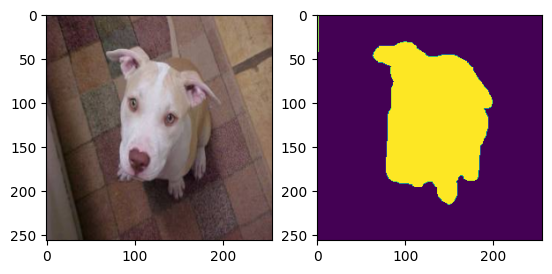

In [ ]:
sample = train_dataset[100]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0))
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())
plt.show()

In [75]:
n_cpu = os.cpu_count()
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=n_cpu)

print(f"Number of cpu: {n_cpu}")

Number of cpu: 2


In [76]:
class Unet_Model(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = unet_model
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        image = image.float() / 255.0
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        dic = batch
        image = dic['image']
        mask = dic["mask"]

        logits_mask = self.forward(image)
        loss = self.loss_fn(logits_mask, mask)
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")

        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [ ]:
print(torch.cuda.is_available())  # True

True


In [77]:
model = Unet_Model()

trainer = pl.Trainer(
    accelerator="auto",
    max_epochs=5,
)

trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | model   | Unet     | 31.0 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.174   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


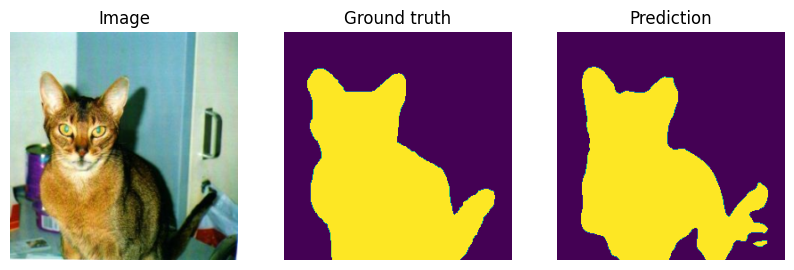

In [80]:
valid_data = iter(valid_dataloader)
batch = next(valid_data)
batch = next(valid_data)
batch = next(valid_data)

with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
    prob_mask = logits.sigmoid()
    pred_mask = (prob_mask > 0.5).float()

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pred_mask):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze())
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze())
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

In [5]:
class SegDataset(Dataset):
    def __init__(self, images, predicted_masks, gt):
        self.images = images
        self.predicted_masks = predicted_masks
        self.gt = gt
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.images[idx]).float() / 255.0
        predicted_mask = torch.from_numpy(self.predicted_masks[idx]).float()
        gt = torch.from_numpy(self.gt[idx]).float()
        return {'image': image, 'mask': predicted_mask, 'gt': gt}

# npy 파일을 다운로드합니다.
images = np.load('/content/drive/MyDrive/images.npy').squeeze(axis=1)
predicted_masks = np.load('/content/drive/MyDrive/coarse_segs.npy').squeeze(axis=1)
gt = np.load('/content/drive/MyDrive/original_masks.npy').squeeze(axis=1)

full_dataset = SegDataset(images, predicted_masks, gt)

total_size = len(full_dataset)
train_size = int(total_size * 0.9)
valid_size = total_size - train_size

train_dataset, valid_dataset = random_split(full_dataset, [train_size, valid_size])

n_cpu = os.cpu_count()
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=n_cpu)

Train dataset size: 3312
Valid dataset size: 368


In [6]:
class Affinity_9(Unet):
    def __init__(self):
        super(Affinity_9, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=4, out_channels=64, kernel_size=3, padding=1)
        self.final_conv = nn.Conv2d(in_channels=64, out_channels=9, kernel_size=3, padding=1)

    def forward(self, x):
        affinity_map = super(Affinity_9, self).forward(x)

        b, c, h, w = affinity_map.size()
        affinity_map = affinity_map.view(b, c, -1)
        affinity_map = F.softmax(affinity_map, dim=1)
        affinity_map = affinity_map.view(b, 9, h, w)

        return affinity_map

affinity_model = Affinity_9()

In [7]:
class CSPN(nn.Module):
    def __init__(self, output_size=(256, 256)):
        super(CSPN, self).__init__()
        self.unfold = nn.Unfold(kernel_size=3, padding=1, stride=1)

    def forward(self, affinity, current_segmentation, coarse_segmentation):
        b, _, h, w = current_segmentation.size()
        current_unfolded = self.unfold(current_segmentation)
        coarse_unfolded = self.unfold(coarse_segmentation)
        current_unfolded[:, 4, :] = coarse_unfolded[:, 4, :]

        affinity = affinity.view(b, 9, -1)
        output = current_unfolded * affinity
        output = output.sum(dim=1, keepdim=True)
        output = output.view(b, 1, h, w)

        return output

cspn_model = CSPN()

In [59]:
class CSPN_Model(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.affinity_model = Affinity_9()
        self.cspn_model = CSPN()
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image, mask):
        combined_input = torch.cat([image, mask], dim=1)
        affinity_map = self.affinity_model(combined_input)
        current_segmentation = mask
        segmentations = []
        for _ in range(6):
            current_segmentation = self.cspn_model(affinity_map, current_segmentation, mask)
            segmentations.append(current_segmentation.detach().cpu())
        return current_segmentation, segmentations

    def shared_step(self, batch, stage):
        dic = batch
        image = dic['image']
        mask = dic['mask']
        gt = dic['gt']

        logits_mask, _ = self.forward(image, mask)
        loss = self.loss_fn(logits_mask, gt)
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), gt.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")

        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [60]:
model = CSPN_Model()

trainer = pl.Trainer(
    accelerator="auto",
    max_epochs=5,
)

trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type       | Params
----------------------------------------------
0 | affinity_model | Affinity_9 | 31.0 M
1 | cspn_model     | CSPN       | 0     
2 | loss_fn        | DiceLoss   | 0     
----------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.197   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


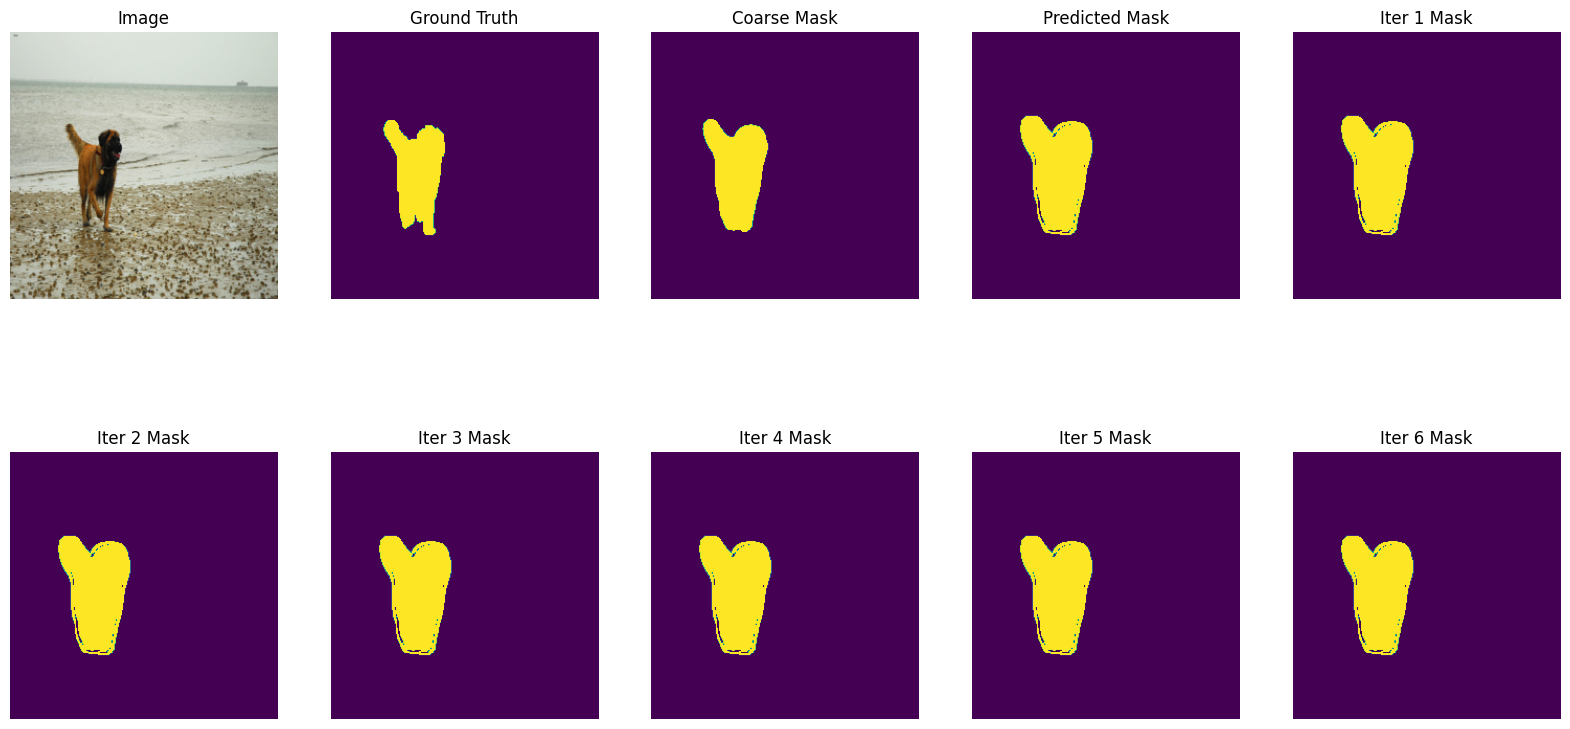

In [67]:
batch = next(iter(valid_dataloader))

with torch.no_grad():
    model.eval()
    logits, segmentations = model(batch["image"], batch["mask"])
    prob_mask = logits.sigmoid()
    pred_mask = (prob_mask > 0.5).float()

    refined_masks = []
    for seg in segmentations:
        seg_prob_mask = seg.sigmoid()
        seg_pred_mask = (seg_prob_mask > 0.5).float()
        refined_masks.append(seg_pred_mask)

fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for image, gt_mask, coarse_mask, pr_mask in zip(batch["image"], batch["gt"], batch["mask"], pred_mask):

    # 원본 이미지 시각화
    axes[0, 0].imshow(image.numpy().transpose(1, 2, 0))
    axes[0, 0].set_title("Image")
    axes[0, 0].axis("off")

    # Ground truth 시각화
    axes[0, 1].imshow(gt_mask.numpy().squeeze())
    axes[0, 1].set_title("Ground Truth")
    axes[0, 1].axis("off")

    # Coarse mask 시각화
    axes[0, 2].imshow(coarse_mask.numpy().squeeze())
    axes[0, 2].set_title("Coarse Mask")
    axes[0, 2].axis("off")

    # Final Prediction 시각화
    axes[0, 3].imshow(pr_mask.numpy().squeeze())
    axes[0, 3].set_title("Predicted Mask")
    axes[0, 3].axis("off")

    # Iteration 시각화
    axes[0, 4].imshow(refined_masks[0].numpy().squeeze())
    axes[0, 4].set_title("Iter 1 Mask")
    axes[0, 4].axis("off")

    axes[1, 0].imshow(refined_masks[1].numpy().squeeze())
    axes[1, 0].set_title("Iter 2 Mask")
    axes[1, 0].axis("off")

    axes[1, 1].imshow(refined_masks[2].numpy().squeeze())
    axes[1, 1].set_title("Iter 3 Mask")
    axes[1, 1].axis("off")

    axes[1, 2].imshow(refined_masks[3].numpy().squeeze())
    axes[1, 2].set_title("Iter 4 Mask")
    axes[1, 2].axis("off")

    axes[1, 3].imshow(refined_masks[4].numpy().squeeze())
    axes[1, 3].set_title("Iter 5 Mask")
    axes[1, 3].axis("off")

    axes[1, 4].imshow(refined_masks[5].numpy().squeeze())
    axes[1, 4].set_title("Iter 6 Mask")
    axes[1, 4].axis("off")

    plt.show()

In [54]:
class Affinity_49(Unet):
    def __init__(self):
        super(Affinity_49, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=4, out_channels=64, kernel_size=3, padding=1)
        self.final_conv = nn.Conv2d(in_channels=64, out_channels=49, kernel_size=7, padding=3)

    def forward(self, x):
        affinity_map = super(Affinity_49, self).forward(x)

        b, c, h, w = affinity_map.size()
        affinity_map = affinity_map.view(b, c, -1)
        affinity_map = F.softmax(affinity_map, dim=1)
        affinity_map = affinity_map.view(b, 49, h, w)

        return affinity_map

affinity_model = Affinity_49()

In [55]:
class Attention(Unet):
    def __init__(self):
        super(Attention, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=4, out_channels=64, kernel_size=3, padding=1)
        self.final_conv = nn.Conv2d(in_channels=64, out_channels=4, kernel_size=1)

    def forward(self, x):
        attention_map = super(Attention, self).forward(x)
        attention_map = torch.sigmoid(attention_map)
        return attention_map

attention_model = Attention()

In [56]:
class DYSPN(nn.Module):
    def __init__(self, output_size=(256, 256)):
        super(DYSPN, self).__init__()
        self.unfold = nn.Unfold(kernel_size=7, padding=3, stride=1)

    def forward(self, affinity, current_segmentation, coarse_segmentation, attention_maps):
        b, _, h, w = current_segmentation.size()

        current_unfolded = self.unfold(current_segmentation)
        coarse_unfolded = self.unfold(coarse_segmentation)

        current_unfolded[:, 24, :] = coarse_unfolded[:, 24, :]

        # 바깥쪽 24개
        outer_indices = [0, 1, 2, 3, 4, 5, 6, 7, 13, 14, 20, 21, 27, 28, 34, 35, 41, 42, 43, 44, 45, 46, 47, 48]
        outer_attention = affinity[:, outer_indices, :, :] * attention_maps[:, 0, :, :].unsqueeze(1)
        # 그다음 층 16개
        middle_indices = [8, 9, 10, 11, 12, 15, 19, 22, 26, 29, 33, 36, 37, 38, 39, 40]
        middle_attention = affinity[:, middle_indices, :, :] * attention_maps[:, 1, :, :].unsqueeze(1)
        # 그다음 층 8개
        inner_indices = [16, 17, 18, 23, 25, 30, 31, 32]
        inner_attention = affinity[:, inner_indices, :, :] * attention_maps[:, 2, :, :].unsqueeze(1)
        # 중앙 1개 (네 번째 Attention 맵)
        center_attention = affinity[:, 24:25, :, :] * attention_maps[:, 3, :, :].unsqueeze(1)

        combined_affinity = torch.cat([outer_attention, middle_attention, inner_attention, center_attention], dim=1)
        output = current_unfolded * combined_affinity.view(b, -1, h * w)
        output = output.sum(dim=1, keepdim=True)
        output = output.view(b, 1, h, w)

        return output

In [65]:
class DYSPN_Model(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.affinity_model = Affinity_49()
        self.attention_model = Attention()
        self.dyspn_model = DYSPN()
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image, mask):
        combined_input = torch.cat([image, mask], dim=1)
        affinity = self.affinity_model(combined_input)
        attention = self.attention_model(combined_input)
        current_segmentation = mask
        segmentations = []
        for _ in range(6):
            current_segmentation = self.dyspn_model(affinity, current_segmentation, mask, attention)
            segmentations.append(current_segmentation.detach().cpu())
        return current_segmentation, segmentations

    def shared_step(self, batch, stage):
        dic = batch
        image = dic['image']
        mask = dic['mask']
        gt = dic['gt']

        logits_mask, _ = self.forward(image, mask)
        loss = self.loss_fn(logits_mask, gt)
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), gt.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")

        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [66]:
model = DYSPN_Model()

trainer = pl.Trainer(
    accelerator="auto",
    max_epochs=5,
)

trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type        | Params
------------------------------------------------
0 | affinity_model  | Affinity_49 | 31.2 M
1 | attention_model | Attention   | 31.0 M
2 | dyspn_model     | DYSPN       | 0     
3 | loss_fn         | DiceLoss    | 0     
------------------------------------------------
62.2 M    Trainable params
0         Non-trainable params
62.2 M    Total params
248.968   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


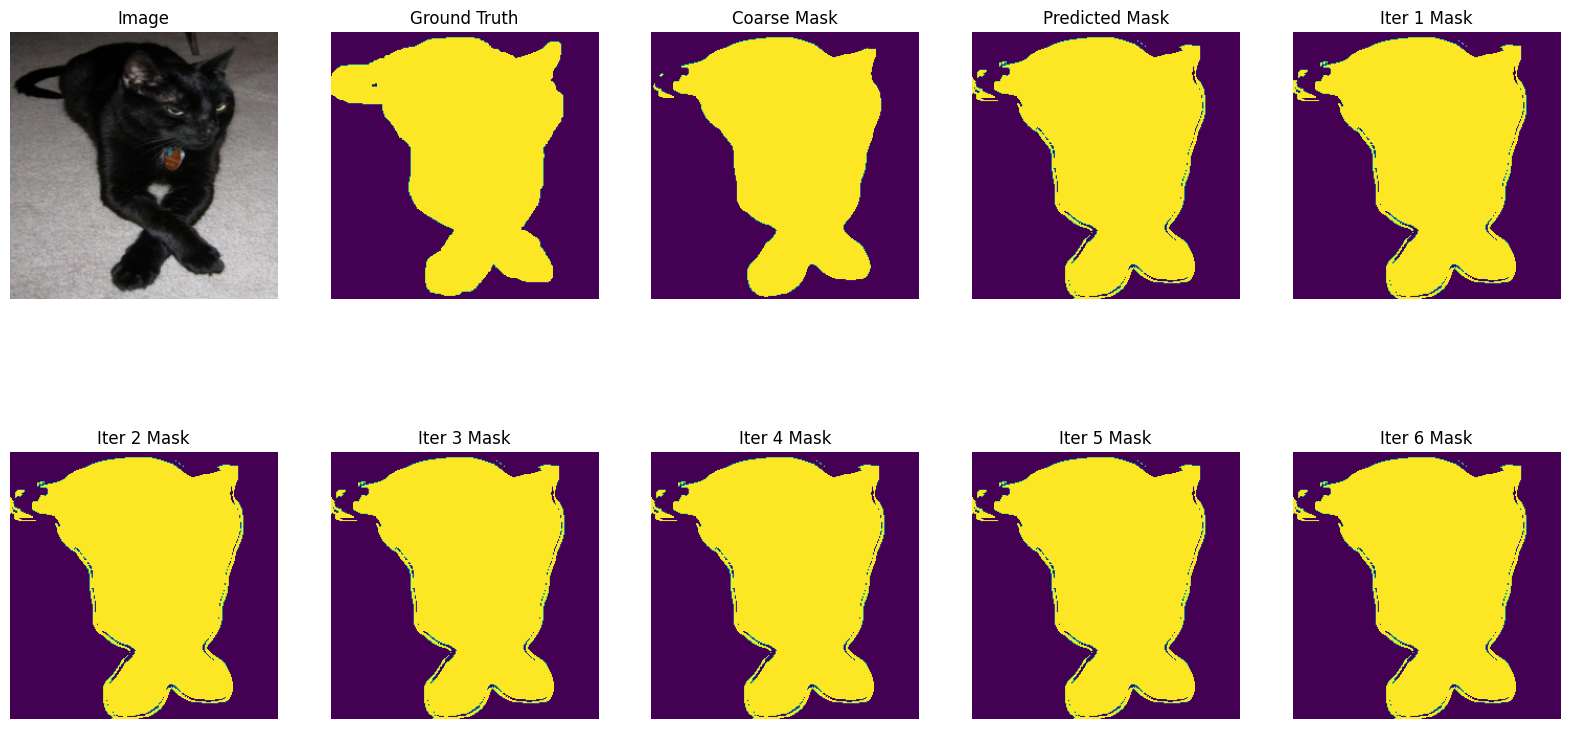

In [68]:
batch = next(iter(valid_dataloader))

with torch.no_grad():
    model.eval()
    logits, segmentations = model(batch["image"], batch["mask"])
    prob_mask = logits.sigmoid()
    pred_mask = (prob_mask > 0.5).float()

    refined_masks = []
    for seg in segmentations:
        seg_prob_mask = seg.sigmoid()
        seg_pred_mask = (seg_prob_mask > 0.5).float()
        refined_masks.append(seg_pred_mask)

fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for image, gt_mask, coarse_mask, pr_mask in zip(batch["image"], batch["gt"], batch["mask"], pred_mask):

    # 원본 이미지 시각화
    axes[0, 0].imshow(image.numpy().transpose(1, 2, 0))
    axes[0, 0].set_title("Image")
    axes[0, 0].axis("off")

    # Ground truth 시각화
    axes[0, 1].imshow(gt_mask.numpy().squeeze())
    axes[0, 1].set_title("Ground Truth")
    axes[0, 1].axis("off")

    # Coarse mask 시각화
    axes[0, 2].imshow(coarse_mask.numpy().squeeze())
    axes[0, 2].set_title("Coarse Mask")
    axes[0, 2].axis("off")

    # Final Prediction 시각화
    axes[0, 3].imshow(pr_mask.numpy().squeeze())
    axes[0, 3].set_title("Predicted Mask")
    axes[0, 3].axis("off")

    # Iteration 시각화
    axes[0, 4].imshow(refined_masks[0].numpy().squeeze())
    axes[0, 4].set_title("Iter 1 Mask")
    axes[0, 4].axis("off")

    axes[1, 0].imshow(refined_masks[1].numpy().squeeze())
    axes[1, 0].set_title("Iter 2 Mask")
    axes[1, 0].axis("off")

    axes[1, 1].imshow(refined_masks[2].numpy().squeeze())
    axes[1, 1].set_title("Iter 3 Mask")
    axes[1, 1].axis("off")

    axes[1, 2].imshow(refined_masks[3].numpy().squeeze())
    axes[1, 2].set_title("Iter 4 Mask")
    axes[1, 2].axis("off")

    axes[1, 3].imshow(refined_masks[4].numpy().squeeze())
    axes[1, 3].set_title("Iter 5 Mask")
    axes[1, 3].axis("off")

    axes[1, 4].imshow(refined_masks[5].numpy().squeeze())
    axes[1, 4].set_title("Iter 6 Mask")
    axes[1, 4].axis("off")

    plt.show()